<a href="https://colab.research.google.com/github/Shashwat-spyder/NYC-Taxi-Trip-Time/blob/main/New_York_Taxi_Duration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [387]:
#Mounting gdrive
from google.colab import drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [388]:
pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from haversine import haversine

In [390]:
nyc_df=pd.read_csv('/content/Drive/My Drive/NYC Taxi Data (1).csv')

In [391]:
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [392]:
nyc_df.shape

(1458644, 11)

In [393]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [394]:
nyc_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


# **Data Cleaning**

Target variable (trip_duration)

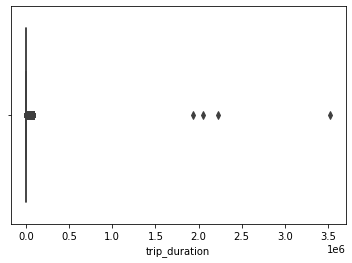

In [395]:
sns.boxplot(nyc_df['trip_duration'])

Clearly there are ouliers in target variable.

In [396]:
nyc_df['trip_duration'].sort_values(ascending=False).head(10)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
Name: trip_duration, dtype: int64

In [397]:
#droping rows having reip_duration >=1000000
nyc_df.drop(nyc_df[nyc_df['trip_duration'] >=1000000].index, inplace = True)

In [398]:
nyc_df['trip_duration'].sort_values(ascending=True).head(10)

207497     1
1382872    1
35196      1
346102     1
1306890    1
1439166    1
918415     1
269418     1
767271     1
810851     1
Name: trip_duration, dtype: int64

In [399]:
nyc_df.drop(nyc_df[nyc_df['trip_duration'] <=150].index, inplace = True)

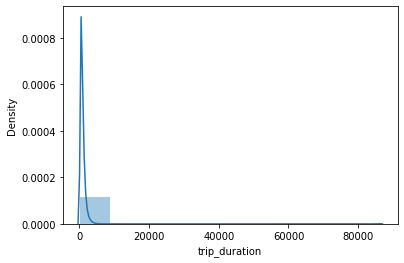

In [400]:
sns.distplot(nyc_df['trip_duration'],bins=10)

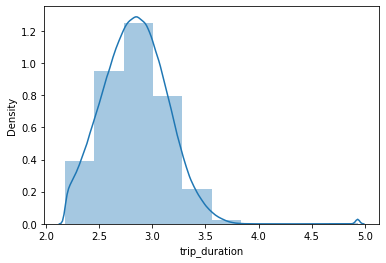

In [401]:
sns.distplot(np.log10(nyc_df['trip_duration']),bins=10)

In [402]:
log=np.log10(nyc_df['trip_duration'].skew())
print(log)
non_log=nyc_df['trip_duration'].skew()
print(non_log)

1.3965733245055967
24.921450993304095


passenger_count

In [403]:
nyc_df['passenger_count'].sort_values(ascending=True)

1433427    0
1257574    0
1364548    0
676906     0
919750     0
          ..
1150222    6
36151      6
332838     6
701511     6
436047     9
Name: passenger_count, Length: 1411467, dtype: int64

In [404]:

nyc_df[nyc_df['passenger_count']==0]['passenger_count'].count()

14

In [405]:
nyc_df['passenger_count'].value_counts()

1    998057
2    204701
5     75787
3     58367
6     46866
4     27674
0        14
9         1
Name: passenger_count, dtype: int64

We can see some null/ zero values and some least occured passenger counts.

In [406]:
#Drop such observations
nyc_df.drop(nyc_df[nyc_df['passenger_count'] >=7].index, inplace = True)
nyc_df.drop(nyc_df[nyc_df['passenger_count'] ==0].index, inplace = True)

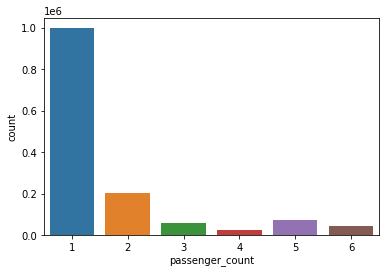

In [407]:
sns.countplot(x='passenger_count', data=nyc_df)

For New York city:

Latitude is between 40.7128 and 40.748817 Longitude is between - 74.0059 and - 73.968285

In [408]:
print('minimum pickup latitude in dataset' , nyc_df['pickup_latitude'].min())
print('minimum pickup longitude in dataset' , nyc_df['pickup_longitude'].min())

minimum pickup latitude in dataset 34.35969543457031
minimum pickup longitude in dataset -121.93334197998048


Lets do some operatios on dropoff and pickup longitude,latitudes to get them under the values respective to new york city.

In [409]:
nyc_df=nyc_df[nyc_df['pickup_latitude']>=40.7128]
nyc_df=nyc_df[nyc_df['pickup_latitude']<=40.748817]
nyc_df=nyc_df[nyc_df['dropoff_latitude']>=40.7128]
nyc_df=nyc_df[nyc_df['dropoff_latitude']<=40.748817]
nyc_df=nyc_df[nyc_df['pickup_longitude']>=-74.0059]
nyc_df=nyc_df[nyc_df['pickup_longitude']<=-73.968285]
nyc_df=nyc_df[nyc_df['dropoff_longitude']<=-73.968285]
nyc_df=nyc_df[nyc_df['dropoff_longitude']>=-74.0059]
nyc_df.shape

(180082, 11)

## **EDA**

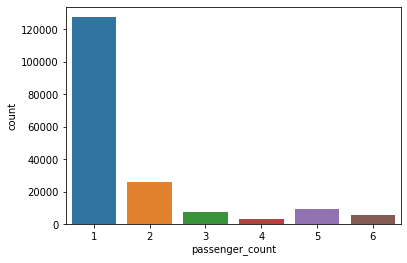

In [410]:
sns.countplot(x='passenger_count', data=nyc_df)

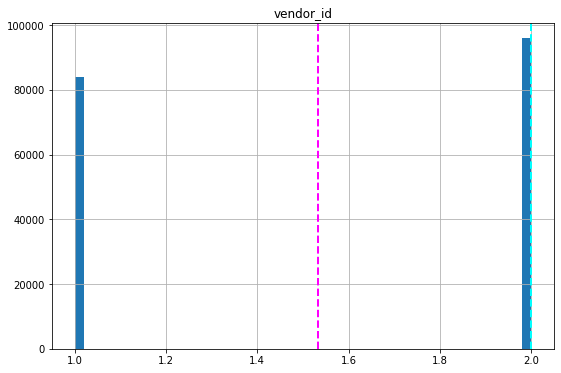

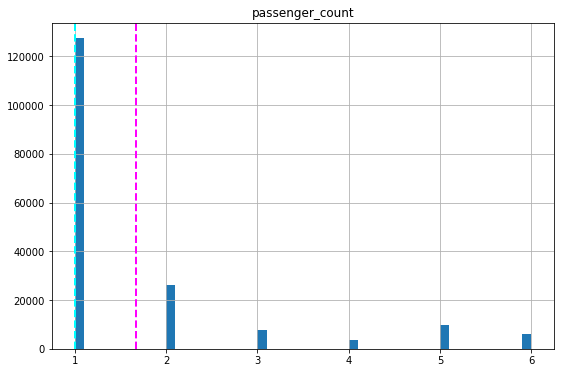

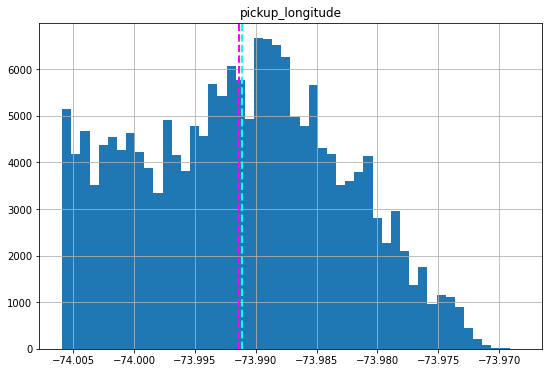

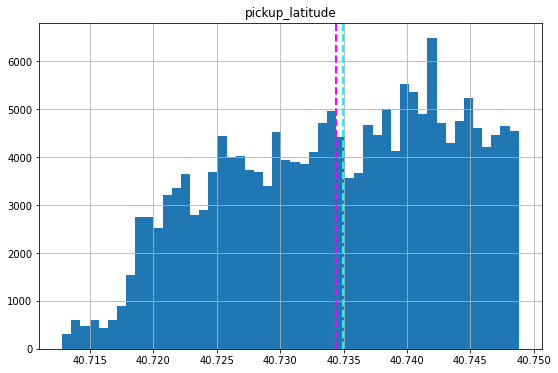

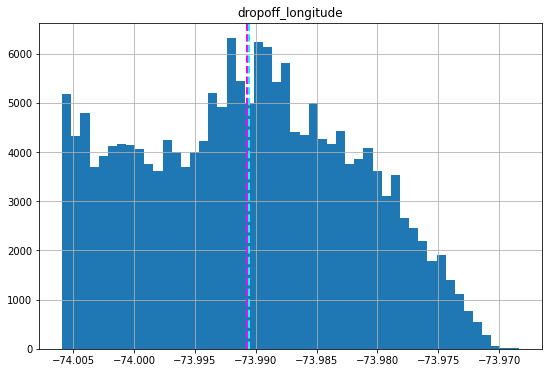

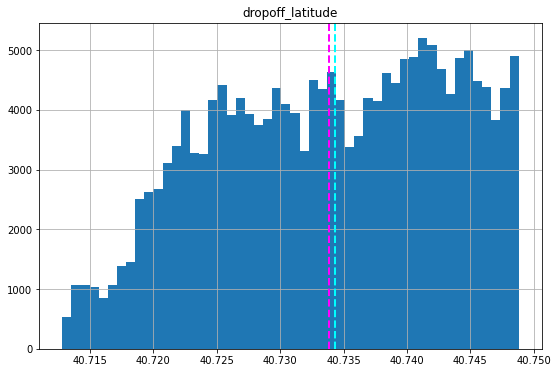

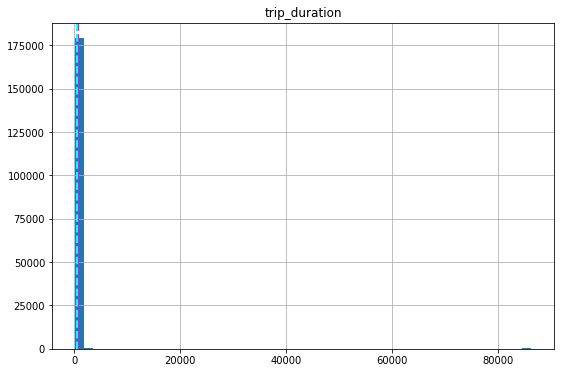

In [411]:
numeric_features=nyc_df.describe().columns

for col in numeric_features:
  fig=plt.figure(figsize=(9,6))
  ax=fig.gca()
  feature=nyc_df[col]
  feature.hist(bins=50, ax=ax)
  ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
  ax.set_title(col)
plt.show()

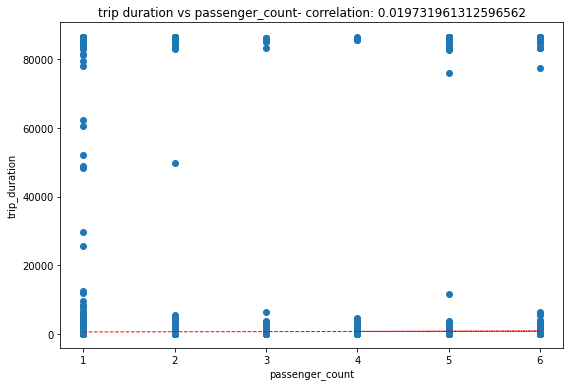

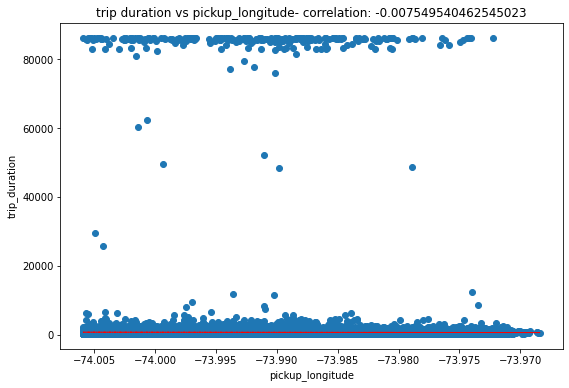

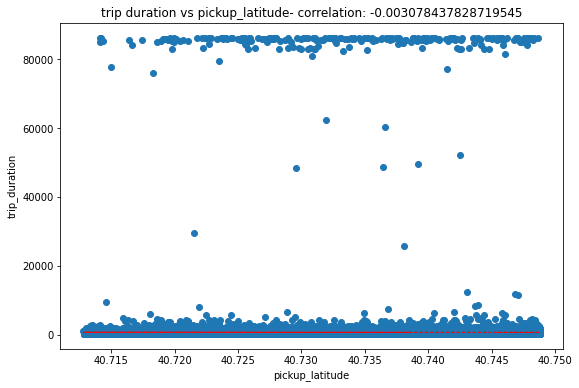

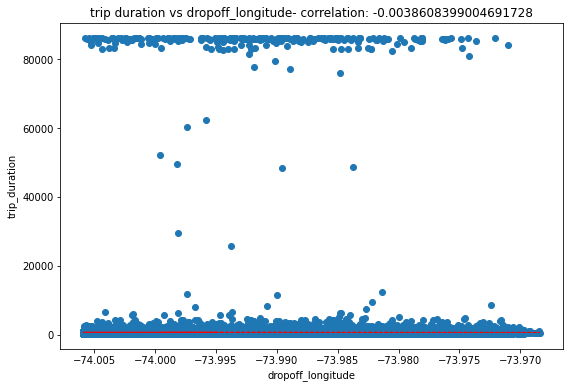

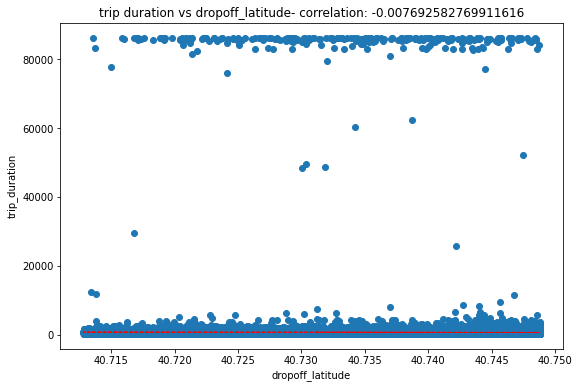

In [412]:
for col in numeric_features[1:-1]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = nyc_df[col]
    label = nyc_df['trip_duration']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('trip_duration')
    ax.set_title('trip duration vs ' + col + '- correlation: ' + str(correlation))

  
    z = np.polyfit(nyc_df[col], nyc_df['trip_duration'], 1)
    y_hat = np.poly1d(z)(nyc_df[col])

    plt.plot(nyc_df[col], y_hat, "r--", lw=1)

plt.show()

We can see from above passenger count, pickup_longitude,pickup_latitude, dropoff_longitude, dropoff_lattitude has little or no correlation
 with target variable.

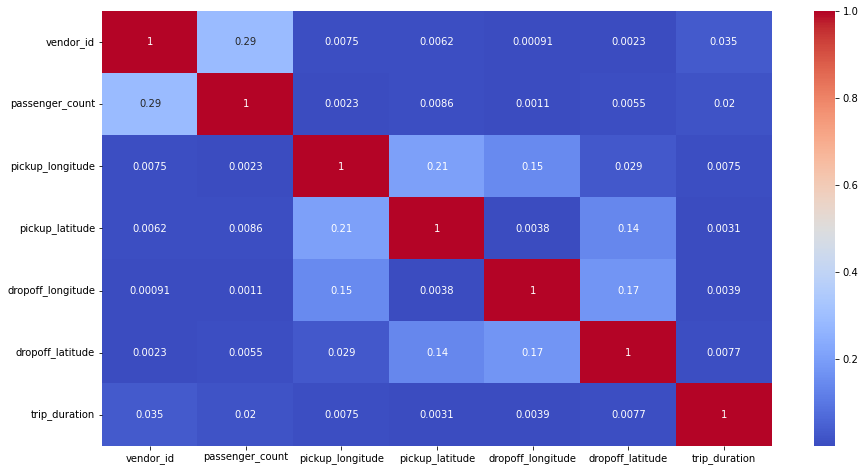

In [413]:
 ## Correlation
plt.figure(figsize=(15,8))
correlation = nyc_df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

In [414]:
def distance(lat1,long1,lat2,long2):
  '''Function to find sperical distance from one point to another
  lat- longitude
  long-longitude
  1-pickup location
  2-dropoff location
  '''
  distance = haversine((lat1,long1),(lat2,long1))+haversine((lat1,long1),(lat1,long2))
  return distance

In [415]:
nyc_df["distance"] = nyc_df.apply(lambda row: distance(row.pickup_latitude, row.pickup_longitude,row.dropoff_latitude,row.dropoff_longitude), axis=1)

In [416]:
nyc_df["speed"] = (nyc_df["distance"]) / ((nyc_df["trip_duration"])/3600)

In [417]:
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,speed
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2.430509,13.197336
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255,1.774807,25.056097
17,id1154431,1,2016-04-14 08:48:26,2016-04-14 09:00:37,1,-73.994255,40.745804,-73.999657,40.723343,N,731,2.952593,14.540812
19,id3390316,2,2016-06-05 13:47:23,2016-06-05 13:51:34,1,-73.983887,40.738197,-73.991203,40.727871,N,251,1.764684,25.310206
37,id2403238,1,2016-06-23 23:00:09,2016-06-23 23:04:46,1,-73.988068,40.728081,-73.980751,40.721470,N,277,1.351631,17.566318


In [418]:
nyc_df['trip_duration'].sort_values(ascending=False)

1269316    86369
1213613    86367
556468     86362
351537     86358
6513       86357
           ...  
1267236      151
794387       151
1191813      151
624476       151
926960       151
Name: trip_duration, Length: 180082, dtype: int64

In [419]:
nyc_df['trip_duration'].max()

86369

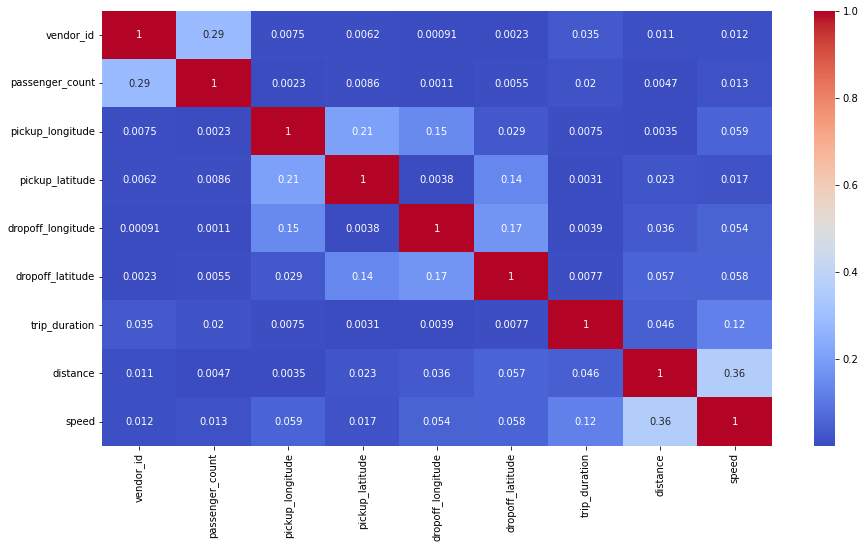

In [420]:
plt.figure(figsize=(15,8))
correlation = nyc_df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

In [421]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [422]:
calc_vif(nyc_df[[i for i in nyc_df.describe().columns if i not in ['trip_duration']]])

,variables,VIF
0,vendor_id,1.139796e+01
1,passenger_count,2.850004e+00
2,pickup_longitude,5.319670e+07
3,pickup_latitude,1.894623e+07
4,dropoff_longitude,5.287917e+07
5,dropoff_latitude,1.811669e+07
6,distance,6.153504e+00
7,speed,6.982068e+00


In [423]:
calc_vif(nyc_df[[i for i in nyc_df.describe().columns if i not in ['trip_duration','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]])

,variables,VIF
0,vendor_id,6.119061
1,passenger_count,2.823534
2,distance,5.454497
3,speed,5.876669


In [424]:
numerical_features=['vendor_id','passenger_count','distance','speed']

In [425]:
nyc_df.drop('id',inplace=True, axis=1)

In [426]:
categorical_features = nyc_df.describe(include=['object','category']).columns

In [427]:
categorical_features

Index(['pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'], dtype='object')

In [428]:
nyc_df['pickup_datetime']

1          2016-06-12 00:43:35
8          2016-05-27 23:12:23
17         2016-04-14 08:48:26
19         2016-06-05 13:47:23
37         2016-06-23 23:00:09
                  ...         
1458618    2016-04-17 01:46:48
1458623    2016-01-18 20:35:30
1458628    2016-05-30 03:08:19
1458630    2016-06-25 03:44:32
1458639    2016-04-08 13:31:04
Name: pickup_datetime, Length: 180082, dtype: object

In [429]:
# Delimit pickup_datetime variable 
nyc_df['pickup_datetime']=pd.to_datetime(nyc_df['pickup_datetime'])
nyc_df['dropoff_datetime']=pd.to_datetime(nyc_df['dropoff_datetime'])

nyc_df['pickup_date'] = nyc_df['pickup_datetime'].dt.date # Extract date
nyc_df['pickup_time'] = nyc_df['pickup_datetime'].dt.time # Extract time

# Delimit dropoff_datetime variables
nyc_df['dropoff_date'] = nyc_df['dropoff_datetime'].dt.date # Extract date
nyc_df['dropoff_time'] = nyc_df['dropoff_datetime'].dt.time # Extract time

# Additional pickup features
nyc_df['pickup_month'] = nyc_df['pickup_datetime'].dt.month # Extract month
nyc_df['pickup_hour'] = nyc_df['pickup_datetime'].dt.hour # Extract hour
nyc_df['pickup_weekday'] = nyc_df['pickup_datetime'].dt.day_name() # Extract day name

# Drop concatentated timestamp columns
nyc_df.drop(['pickup_datetime'], axis = 1, inplace = True)
nyc_df.drop(['dropoff_datetime'], axis = 1, inplace = True)

# Confirm changes
nyc_df.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'speed', 'pickup_date', 'pickup_time',
       'dropoff_date', 'dropoff_time', 'pickup_month', 'pickup_hour',
       'pickup_weekday'],
      dtype='object')

In [430]:
categorical_features

Index(['pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'], dtype='object')

In [433]:
numerical_features

['vendor_id', 'passenger_count', 'distance', 'speed']

In [450]:
nyc_df['pickup_latitude'].max()

40.74881362915039

In [511]:
from scipy.stats import zscore
#Train test split
# numeric_cols = carprice.select_dtypes(include=[np.number]).columns
X = nyc_df[numerical_features]

In [512]:
nyc_df['trip_duration'].max()

86369

In [513]:
y = np.log10(nyc_df['trip_duration'])

In [514]:
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.2, random_state = 0) 
print(X_train.shape)
print(X_test.shape)

(144065, 4)
(36017, 4)


In [515]:
reg = LinearRegression().fit(X_train, y_train)

In [516]:
reg.score(X_train, y_train)

0.7807914997339644

In [517]:
reg.coef_

array([ 0.00507722,  0.00075288,  0.21461174, -0.02866877])

In [518]:
reg.intercept_

2.6676960339702664

In [519]:
y_pred = reg.predict(X_test)

In [520]:
from sklearn.metrics import mean_squared_error

MSE  = mean_squared_error(y_test, y_pred)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 0.011221178045884036
RMSE : 0.10593006204984512


In [521]:
from sklearn import metrics
print('\nLinear Regression Performance Metrics')
print('R^2=',metrics.explained_variance_score(y_test,y_pred))
print('MAE:',metrics.mean_absolute_error(y_test,y_pred))
print('MSE:',metrics.mean_squared_error(y_test,y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))


Linear Regression Performance Metrics
R^2= 0.8007487030694047
MAE: 0.05476623311331168
MSE: 0.011221178045884036
RMSE: 0.10593006204984512


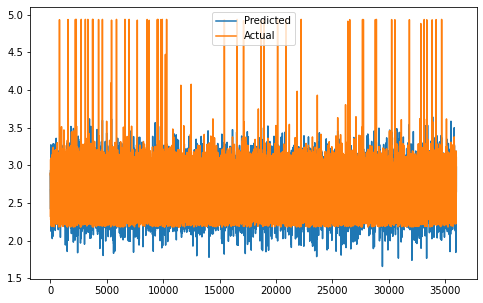

In [522]:
plt.figure(figsize=(8,5))
plt.plot(y_pred)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()